<div style="text-align:center;">
    <h1>Data-driven Estimation of Pharmacological Prescription Duration using Python</h1>
    <h3>Assignment 3 - Implementation and EDA</h3>
    <h4>Authors:</h4>
    <ul style="list-style:none;">
        <li>👤 Elgen Mar Arinasa</li>
        <li>👤 Shawn Jurgen Mayol</li>
    </ul>
    <hr>
</div>


<h2 style="color:#4B0082;">📖 Introduction</h2>
<p>
    Accurate estimation of prescription durations is critical in pharmacoepidemiological research, directly affecting assessments of medication adherence, clinical efficacy, and overall patient safety. Traditional methods often struggle with incomplete or imprecise data, necessitating innovative, data-driven approaches such as the Sessa Empirical Estimator (SEE). According to recent studies (e.g., Sessa et al., 2024; Carracedo-Martinez et al., 2022), clustering techniques like K-Means and DBSCAN significantly improve the robustness and accuracy of prescription duration estimation by identifying naturally occurring medication usage patterns.

    In this notebook, leveraging insights from these research papers, especially around data scaling necessity due to distribution skewness and varying magnitudes in dosage data, we perform comprehensive preprocessing and exploratory data analysis on the provided dataset (medeventsATC.csv). Subsequently, we apply clustering techniques within the SEE framework, critically compare their performance, and offer detailed conclusions that highlight their methodological strengths and limitations.
</p>


<h2 style="color:#4B0082;">🎯 Objectives</h2>
<p>This notebook aims to accomplish the following tasks comprehensively:</p>
<ol>
    <li><strong>Load and inspect</strong> the provided dataset for preliminary insights.</li>
    <li><strong>Clean and preprocess</strong> the dataset to prepare for robust analysis.</li>
    <li>Conduct thorough <strong>Exploratory Data Analysis (EDA)</strong> to understand data patterns and distributions clearly.</li>
    <li><strong>Implement</strong> the <em>Sessa Empirical Estimator (SEE)</em> using <strong>K-Means clustering</strong>.</li>
    <li><strong>Implement</strong> the <em>Sessa Empirical Estimator (SEE)</em> using <strong>DBSCAN clustering</strong> as an alternative approach.</li>
    <li><strong>Perform comparative analyses and visualizations</strong> to evaluate and interpret the effectiveness of both clustering techniques.</li>
    <li><strong>Provide comprehensive conclusions, insights, and a detailed discussion</strong> of findings, highlighting the strengths and weaknesses of the clustering methodologies used.</li>
</ol>


<h2 style="color:#4B0082;">📚 Import Required Libraries</h2>
<p>We begin by importing all necessary libraries for data handling, visualization, and machine learning.</p>


In [649]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import os


### 📝 Column Name Mapping (R → Python):

- **pnr** (R) → **PATIENT_ID** (Python)
- **eksd** (R) → **DATE** (Python)
- **ATC** (R) → **CATEGORY** (Python)
- **dur_original** (R) → **DURATION** (Python)
- **perday** (R) → **PERDAY**  (Python)

### ⚠️ Clarification on CATEGORY Columns:

In the original simplified R implementation, medications were represented by a single categorical column called `ATC`. In this dataset, medications are categorized at three hierarchical levels:

- **CATEGORY** (Specific ATC medication codes)
- **CATEGORY_L1** (Broader medication group)
- **CATEGORY_L2** (Detailed medication subgroup)

For clustering and SEE estimation methods (K-Means and DBSCAN), **CATEGORY** (ATC codes) was chosen as it directly parallels the original `ATC` column in the R example.



<h2 style="color:#4B0082;">📂 Data Loading and Initial Inspection</h2>
<p>First, we load the provided dataset and perform basic inspection to understand its structure and contents.</p>


In [650]:
import pandas as pd

# Load dataset
data = pd.read_csv('medeventsATC.csv')

# Quick inspection
print("Dataset Dimensions:", data.shape)
data.head()


Dataset Dimensions: (1564, 7)


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
0,1,2057-09-04,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
1,1,2058-06-03,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
2,1,2058-07-09,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
3,1,2056-10-09,41.666667,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
4,1,2056-12-10,40.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"


<h2 style="color:#4B0082;">🛠️ Data Preprocessing</h2>
<p>We preprocess the data by handling missing values, converting date formats, and ensuring correct data types.</p>


In [651]:
# Check for missing values
missing_data = data.isnull().sum()
print(missing_data)

# Convert DATE column to datetime
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

# Drop critical missing entries
data.dropna(subset=['PATIENT_ID', 'DATE', 'DURATION', 'CATEGORY'], inplace=True)

# Verify data types after cleaning
data.info()


PATIENT_ID     0
DATE           0
DURATION       0
PERDAY         0
CATEGORY       0
CATEGORY_L1    0
CATEGORY_L2    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PATIENT_ID   1564 non-null   int64         
 1   DATE         1564 non-null   datetime64[ns]
 2   DURATION     1564 non-null   float64       
 3   PERDAY       1564 non-null   float64       
 4   CATEGORY     1564 non-null   object        
 5   CATEGORY_L1  1564 non-null   object        
 6   CATEGORY_L2  1564 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 85.7+ KB


 <h4> Detailed statistics for Dosage Per Day </h4>

In [652]:
# Detailed statistics for Dosage Per Day
data['PERDAY'].describe()


count    1.564000e+03
mean     1.079554e+05
std      3.688593e+05
min      6.666667e-02
25%      1.000000e+02
50%      6.000000e+02
75%      3.333333e+03
max      8.000000e+06
Name: PERDAY, dtype: float64

 <h4>Detailed statistics for Medication Duration</h4>

In [653]:
# Detailed statistics for Medication Duration
data['DURATION'].describe()

count    1564.000000
mean       38.339786
std        33.581154
min         2.000000
25%        28.000000
50%        30.000000
75%        35.377358
max       400.000000
Name: DURATION, dtype: float64

<h2 style="color:#4B0082;">🔍 Exploratory Data Analysis (EDA)</h2>
<p>
    The purpose of EDA is to discover patterns, detect anomalies, and validate data assumptions through statistical summaries and visualizations.
</p>


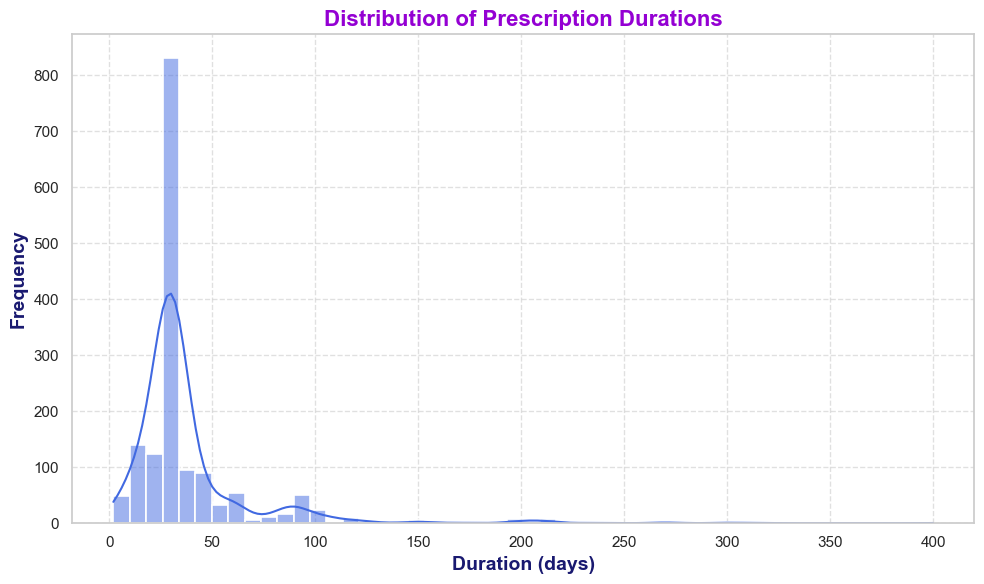

In [654]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid")  # Background style for a cleaner plot

# Create the figure and size
plt.figure(figsize=(10, 6))

# Color palette for better aesthetics
sns.histplot(data['DURATION'], bins=50, kde=True, color='royalblue', linewidth=1.2)

# Add title and customize font properties
plt.title('Distribution of Prescription Durations', fontsize=16, fontweight='bold', color='darkviolet')

# Labeling axes with improved font
plt.xlabel('Duration (days)', fontsize=14, fontweight='bold', color='midnightblue')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='midnightblue')

# Add grid lines for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


<h2 style="color:#4B0082;">Visualization: Distribution of Medication Dosage (PERDAY): </h2>

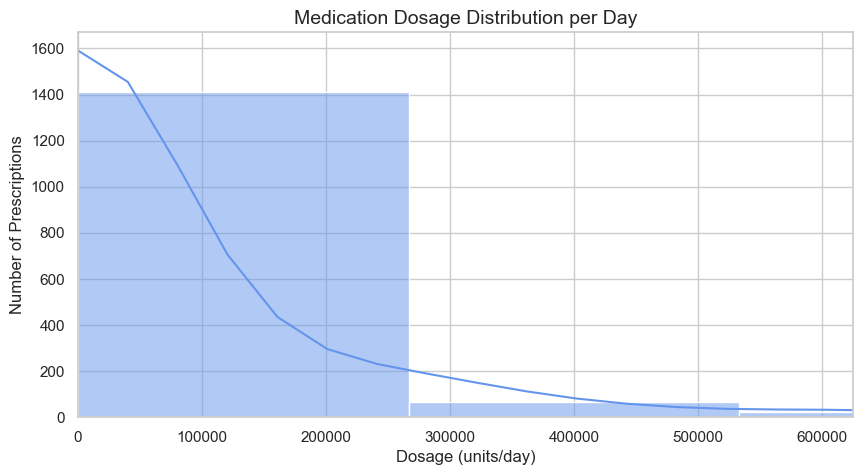

In [655]:
plt.figure(figsize=(10, 5))
sns.histplot(data['PERDAY'], bins=30, kde=True, color='cornflowerblue')
plt.title('Medication Dosage Distribution per Day', fontsize=14)
plt.xlabel('Dosage (units/day)')
plt.ylabel('Number of Prescriptions')
plt.xlim(0, data['PERDAY'].quantile(0.95))  # limited to 95th percentile for better visualization
plt.show()


<h4>📊 Trend Analysis of Medication Prescriptions Over Time (Yearly) </h4>

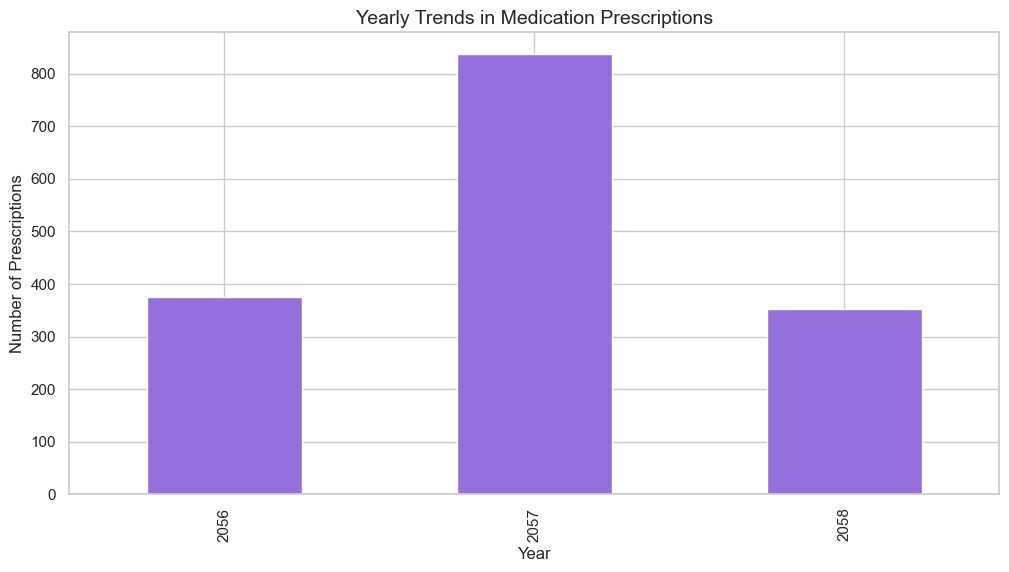

In [656]:
data['DATE'] = pd.to_datetime(data['DATE'])
plt.figure(figsize=(12, 6))
data['DATE'].dt.year.value_counts().sort_index().plot(kind='bar', color='mediumpurple')
plt.title('Yearly Trends in Medication Prescriptions', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Prescriptions')
plt.show()


<h2>✅ Visualizing CATEGORY (Detailed Categories):</h2>

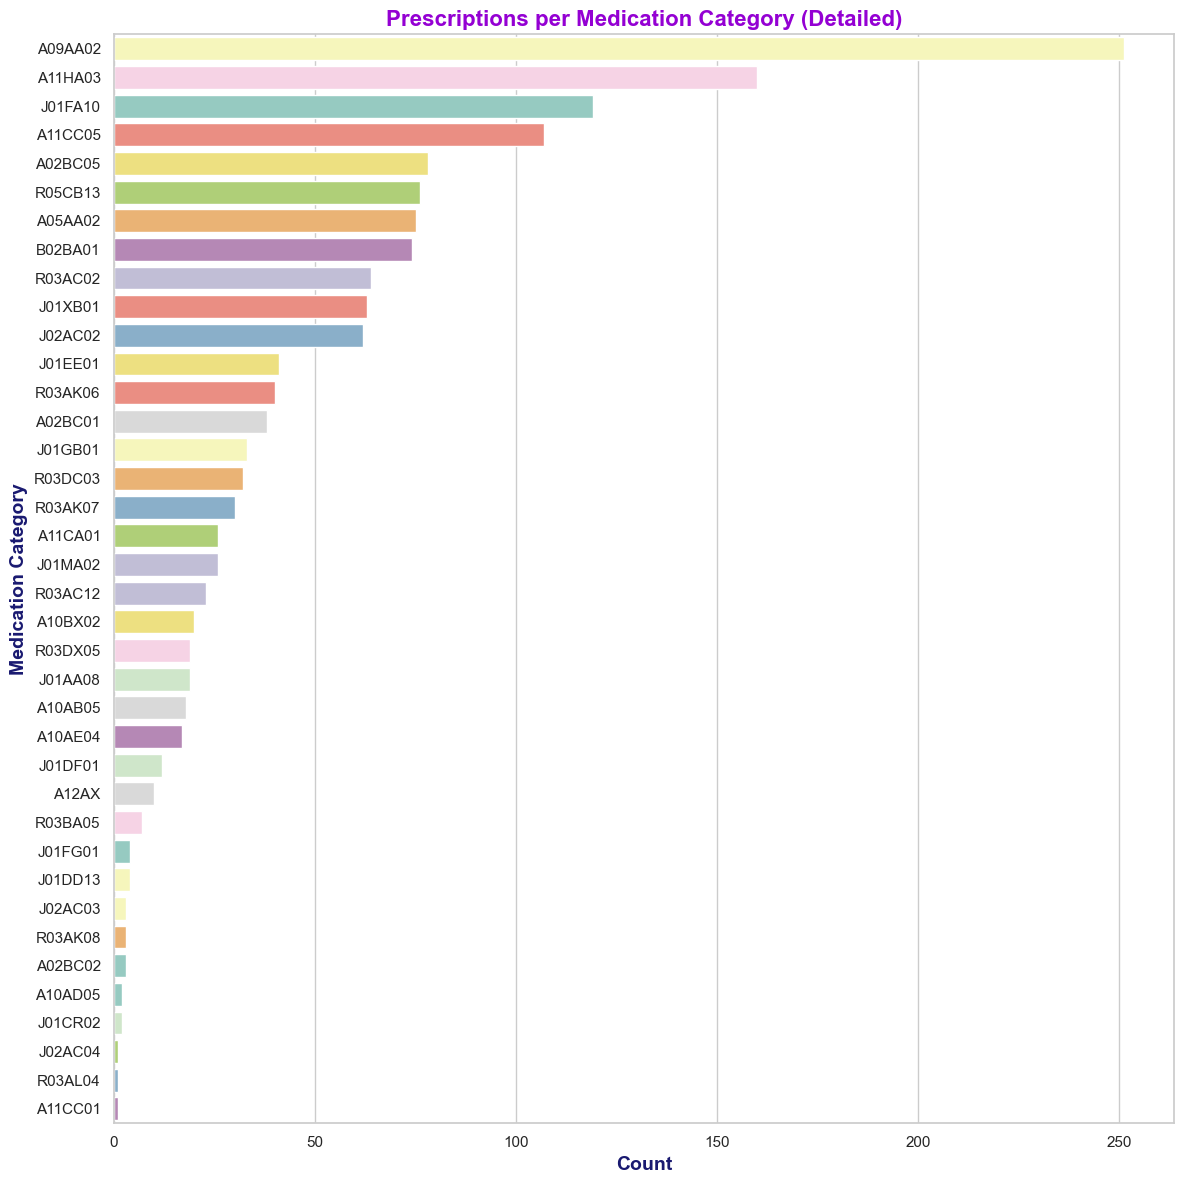

In [657]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and size
plt.figure(figsize=(12, 12))

# Use a more customized color palette for distinct category coloring
unique_categories = data['CATEGORY'].nunique()
palette = sns.color_palette("Set3", unique_categories)

# Create countplot with customized palette
sns.countplot(y='CATEGORY', data=data, 
              order=data['CATEGORY'].value_counts().index, 
              hue='CATEGORY', palette=palette, legend=False)

# Title and labels with enhanced font styles
plt.title('Prescriptions per Medication Category (Detailed)', fontsize=16, fontweight='bold', color='darkviolet')
plt.xlabel('Count', fontsize=14, fontweight='bold', color='midnightblue')
plt.ylabel('Medication Category', fontsize=14, fontweight='bold', color='midnightblue')

# Add a tight layout for cleaner visualization
plt.tight_layout()

# Show the plot
plt.show()


<h3 style="color:#00008B;">💊 Prescription Counts by Medication Category (CATEGORY_L1)</h3>
<p>Analyzing prescription frequency by primary medication category to understand prescription trends.</p>


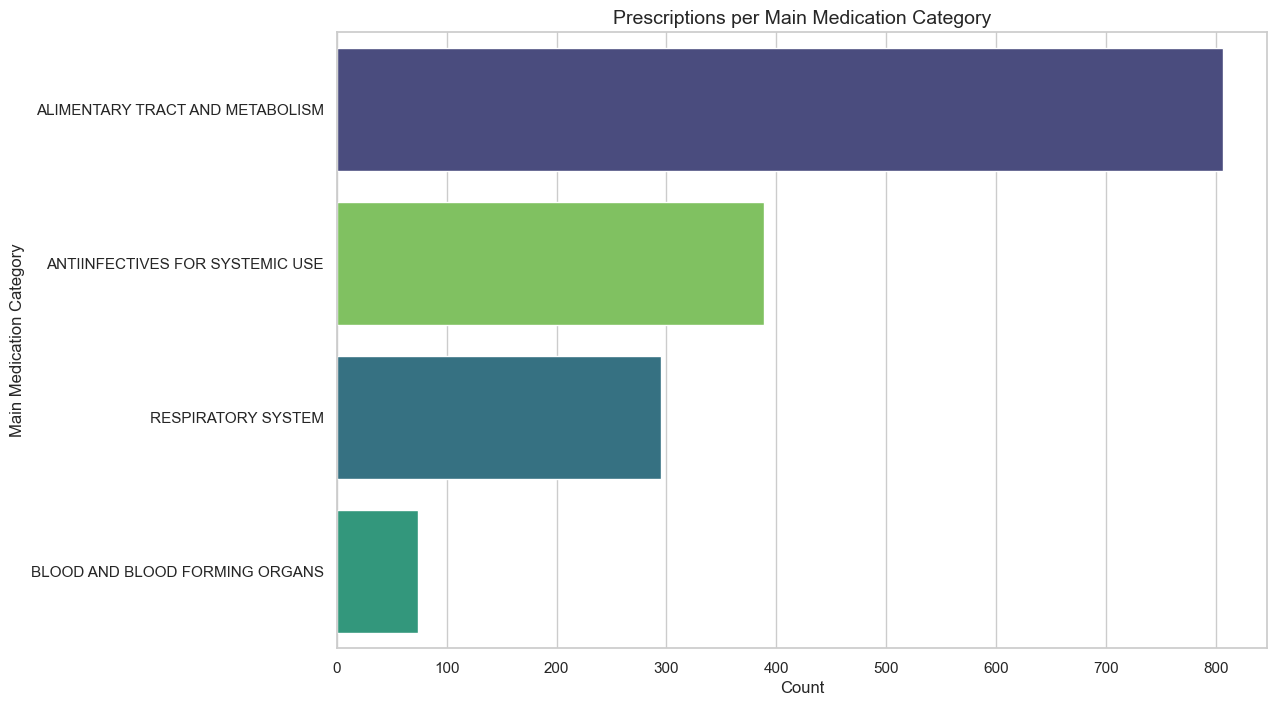

In [658]:
plt.figure(figsize=(12, 8))
sns.countplot(y='CATEGORY_L1', data=data, 
              order=data['CATEGORY_L1'].value_counts().index, 
              hue='CATEGORY_L1', palette='viridis', legend=False)
plt.title('Prescriptions per Main Medication Category', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Main Medication Category')
plt.show()


<h3 style="color:#00008B;">✅ Visualizing CATEGORY_L2 (Subcategories):</h3>

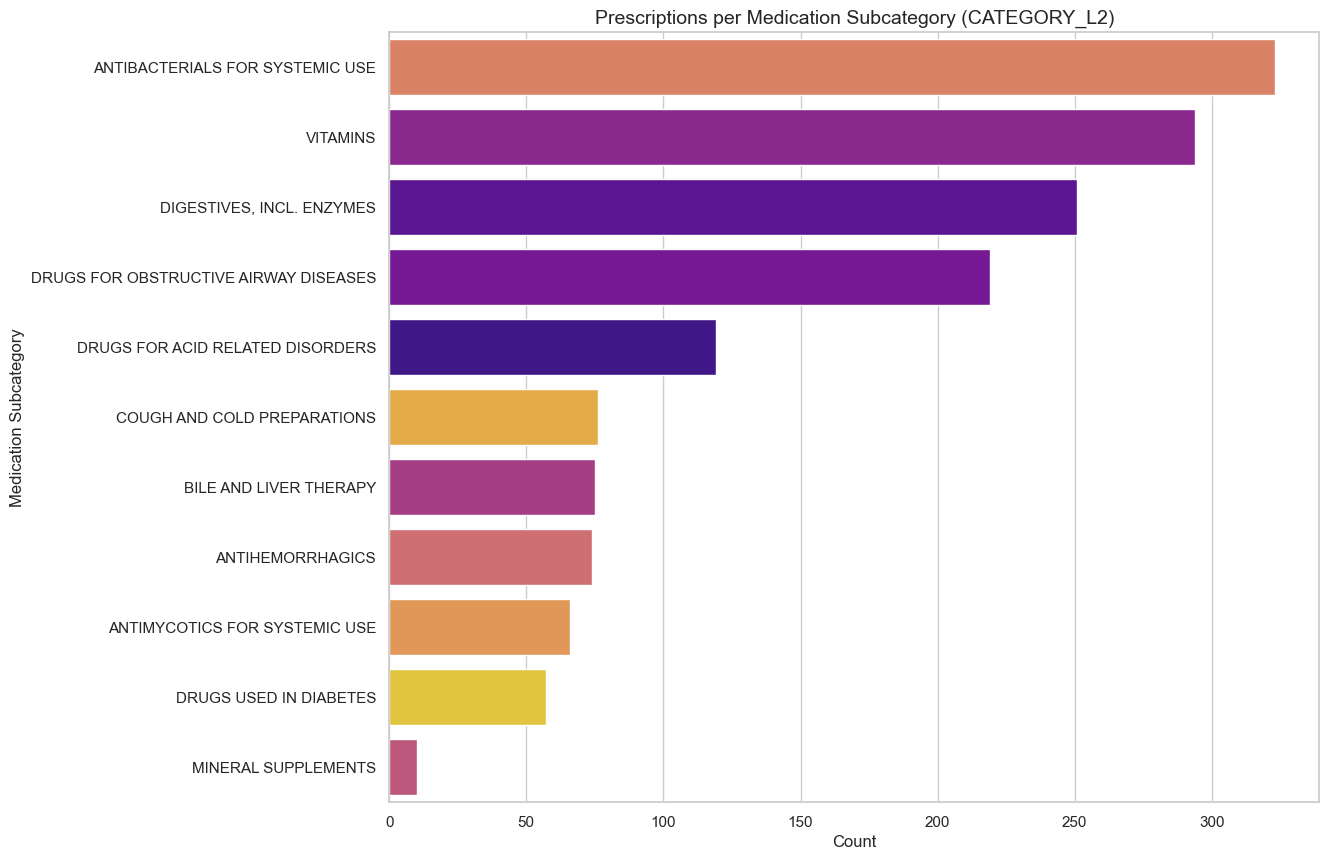

In [659]:
plt.figure(figsize=(12, 10))
sns.countplot(y='CATEGORY_L2', data=data, 
              order=data['CATEGORY_L2'].value_counts().index, 
              hue='CATEGORY_L2', palette='plasma', legend=False)
plt.title('Prescriptions per Medication Subcategory (CATEGORY_L2)', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Medication Subcategory')
plt.show()


<h3 style="color:#00008B;">📅 Temporal Patterns of Prescriptions</h3>
<p>Examining monthly trends to detect seasonal patterns or temporal shifts in prescription frequency.</p>


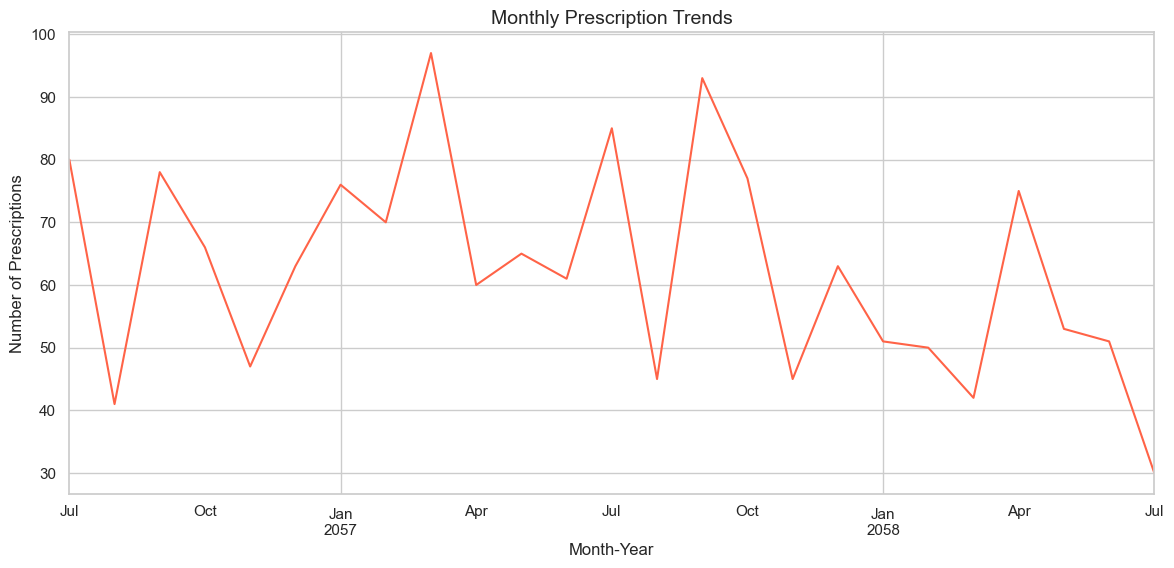

In [660]:
# Set date as index for temporal analysis
data.set_index('DATE', inplace=True)

# Monthly prescription counts
monthly_prescriptions = data.resample('M').size()

# Plotting the temporal trend
plt.figure(figsize=(14,6))
monthly_prescriptions.plot(color='tomato')
plt.title('Monthly Prescription Trends', fontsize=14)
plt.xlabel('Month-Year')
plt.ylabel('Number of Prescriptions')
plt.show()

# Resetting index for further analysis
data.reset_index(inplace=True)


<h3 style="color:#00008B;">🧑‍🤝‍🧑 Patient-Level Prescription Patterns</h3>
<p>Investigating how prescription behavior varies among patients, focusing on the number of prescriptions per individual.</p>


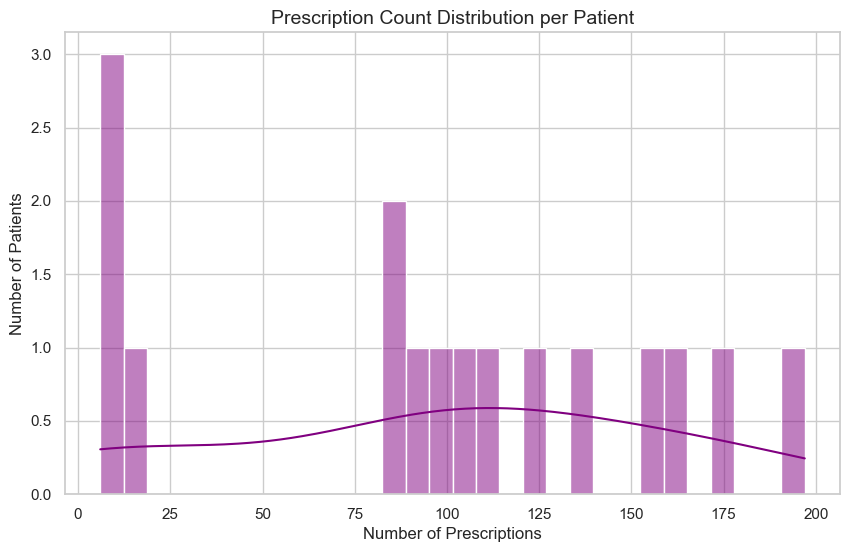

In [661]:
# Number of prescriptions per patient
patient_counts = data['PATIENT_ID'].value_counts()

# Plot distribution
plt.figure(figsize=(10,6))
sns.histplot(patient_counts, bins=30, kde=True, color='purple')
plt.title('Prescription Count Distribution per Patient', fontsize=14)
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Patients')
plt.show()


<h3 style="color:#00008B;">🔗 Correlation Analysis</h3>
<p>Identifying correlations between numerical features such as prescription duration and dosage per day.</p>


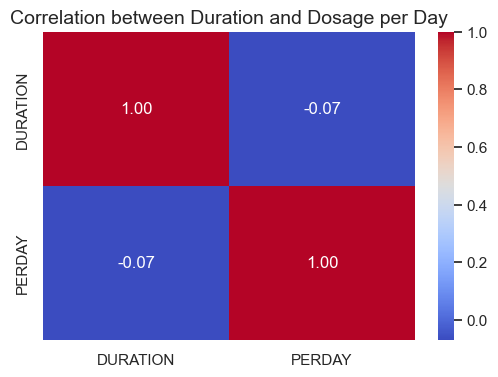

In [662]:
corr_matrix = data[['DURATION', 'PERDAY']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Duration and Dosage per Day', fontsize=14)
plt.show()


<h3 style="color:#00008B;">🚨 Outlier Detection in Prescription Duration</h3>
<p>Using boxplots to visualize and detect potential outliers that could impact clustering accuracy.</p>


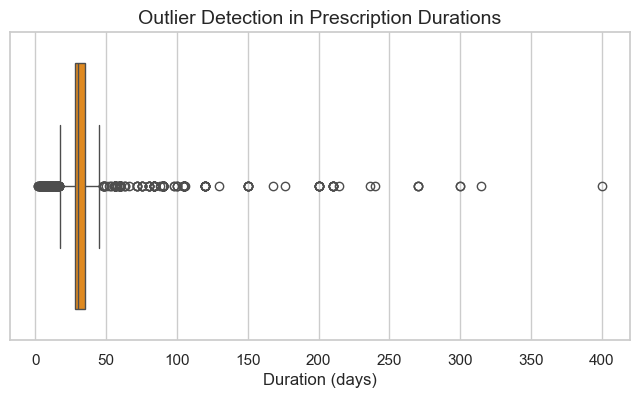

count    1564.000000
mean       38.339786
std        33.581154
min         2.000000
25%        28.000000
50%        30.000000
75%        35.377358
max       400.000000
Name: DURATION, dtype: float64

In [663]:
plt.figure(figsize=(8,4))
sns.boxplot(x=data['DURATION'], color='darkorange')
plt.title('Outlier Detection in Prescription Durations', fontsize=14)
plt.xlabel('Duration (days)')
plt.show()

data['DURATION'].describe()


<h2>🚨 Additional Outlier Detection (Boxplots) </h2>

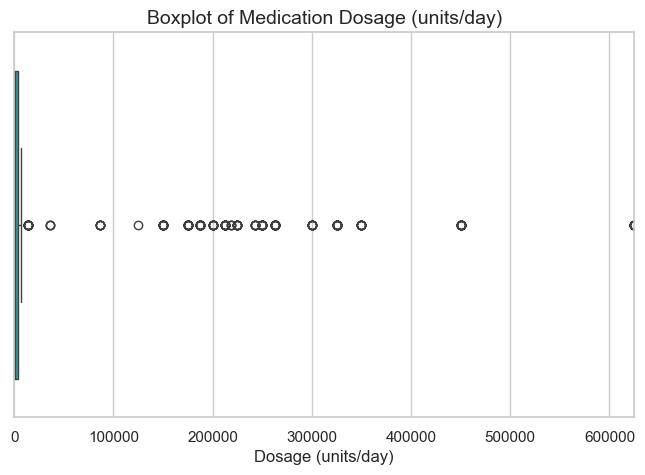

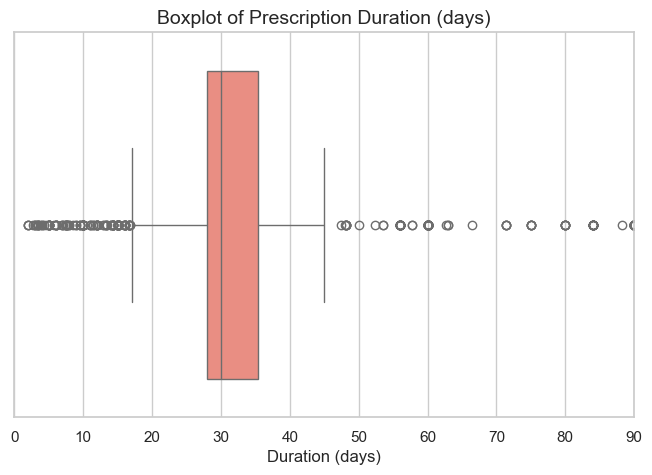

In [664]:
# Outlier Detection for Dosage per Day
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['PERDAY'], color='lightseagreen')
plt.title('Boxplot of Medication Dosage (units/day)', fontsize=14)
plt.xlabel('Dosage (units/day)')
plt.xlim(0, data['PERDAY'].quantile(0.95))
plt.show()

# Outlier Detection for Prescription Duration
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['DURATION'], color='salmon')
plt.title('Boxplot of Prescription Duration (days)', fontsize=14)
plt.xlabel('Duration (days)')
plt.xlim(0, data['DURATION'].quantile(0.95))
plt.show()


<h2 style="color:#4B0082;">📌 EDA Summary and Insights</h2>
<ul>
    <li>Prescription durations show a wide distribution, indicating diverse prescribing behaviors.</li>
    <li>Dominant medication categories suggest targeted areas for further analysis.</li>
    <li>Clear temporal trends and distinct patient-level prescription patterns provide valuable insights for subsequent clustering analysis.</li>
</ul>
<p>These results provide the groundwork needed for implementing the Sessa Empirical Estimator (SEE) using K-Means and DBSCAN in the subsequent notebook sections.</p>


<h2 style="color:#03208B;">⚙️ Implementation of Sessa Empirical Estimator (SEE) with K-Means</h2>

<h4>Step 1: Feature Scaling (Essential due to Skewness and Magnitude Variation)<h4>

In [665]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['DURATION', 'PERDAY']])


<h4> Step 2: Implementing K-Means Clustering </h4>

In [666]:
kmeans = KMeans(n_clusters=3, random_state=1234, n_init=10)
clusters_kmeans = kmeans.fit_predict(scaled_features)
data['KMeans_Cluster'] = clusters_kmeans


<h4> Step 3: Visualizing K-Means Clusters</h4>

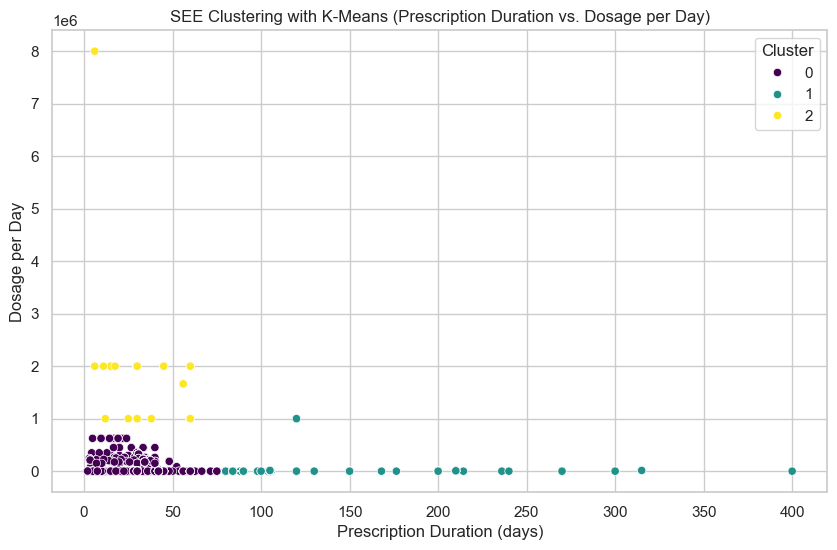

In [667]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DURATION', y='PERDAY', data=data, hue='KMeans_Cluster', palette='viridis')
plt.title('SEE Clustering with K-Means (Prescription Duration vs. Dosage per Day)')
plt.xlabel('Prescription Duration (days)')
plt.ylabel('Dosage per Day')
plt.legend(title='Cluster')
plt.show()


In [668]:
print(data['KMeans_Cluster'].value_counts())


KMeans_Cluster
0    1363
1     141
2      60
Name: count, dtype: int64


<h2 style="color:#03208B;">⚙️ Implementation of SEE with DBSCAN Clustering</h2>

<h4> Step 1: DBSCAN Implementation </h4>

In [669]:
print(dbscan.get_params())  

{'algorithm': 'auto', 'eps': 1, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 10, 'n_jobs': None, 'p': None}


In [670]:
dbscan = DBSCAN(eps=1, min_samples=10)
clusters_dbscan = dbscan.fit_predict(scaled_features)
data['DBSCAN_Cluster'] = clusters_dbscan 


 <h4> Step 2: Visualizing DBSCAN Clusters </h4>

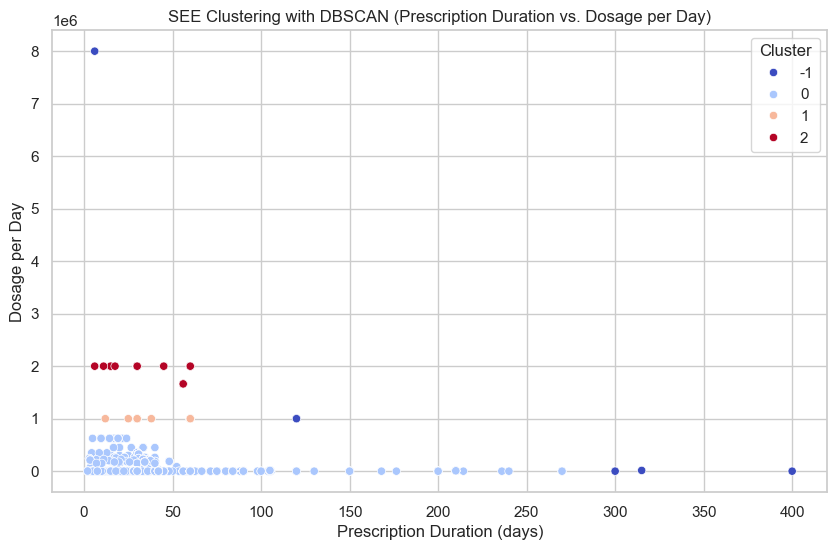

In [671]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DURATION', y='PERDAY', data=data, hue='DBSCAN_Cluster', palette='coolwarm')
plt.title('SEE Clustering with DBSCAN (Prescription Duration vs. Dosage per Day)')
plt.xlabel('Prescription Duration (days)')
plt.ylabel('Dosage per Day')
plt.legend(title='Cluster')
plt.show()


In [672]:
print(data['DBSCAN_Cluster'].value_counts())


DBSCAN_Cluster
 0    1497
 1      31
 2      28
-1       8
Name: count, dtype: int64


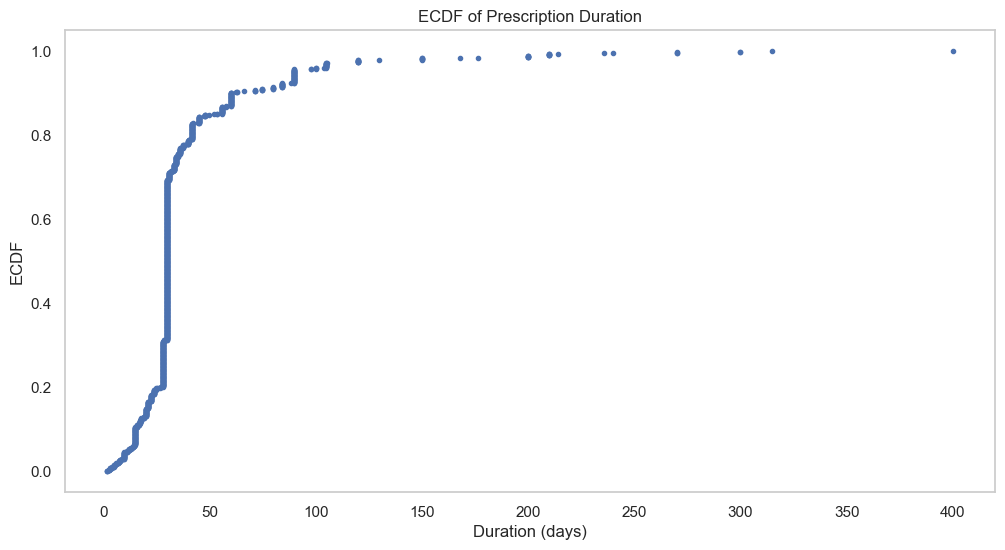

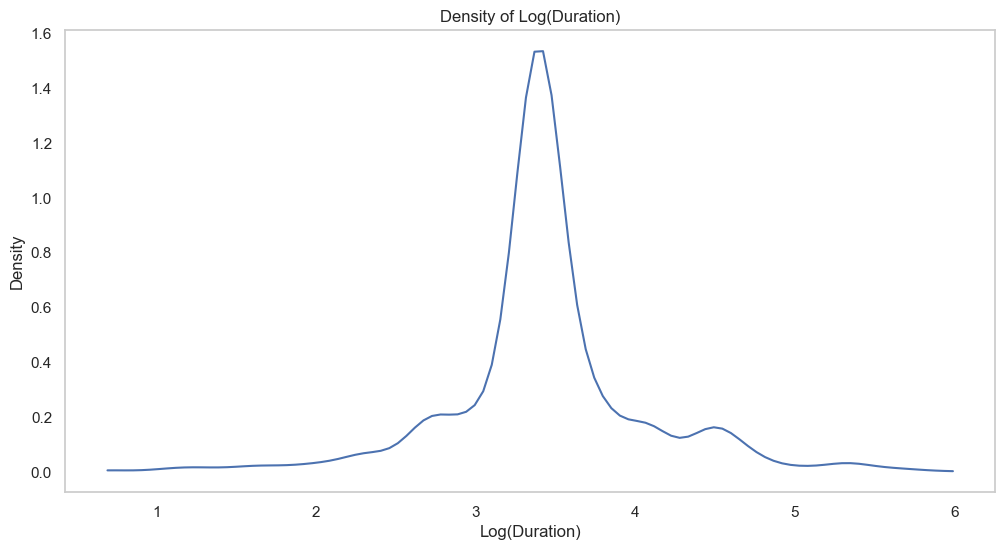

In [673]:
# ECDF Plot
from statsmodels.distributions.empirical_distribution import ECDF
intervals = data['DURATION']
ecdf = ECDF(intervals)

plt.figure(figsize=(12, 6))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.title('ECDF of Prescription Duration')
plt.xlabel('Duration (days)')
plt.ylabel('ECDF')
plt.grid()
plt.show()

# Density plot (log scale)
import numpy as np
from scipy.stats import gaussian_kde

log_intervals = np.log(intervals[intervals > 0])
density = gaussian_kde(log_intervals)
xs = np.linspace(min(log_intervals), max(log_intervals), 100)

plt.figure(figsize=(12, 6))
plt.plot(xs, density(xs))
plt.title('Density of Log(Duration)')
plt.xlabel('Log(Duration)')
plt.ylabel('Density')
plt.grid()
plt.show()


<h2> Callable Functions</h2>
<h3> 🟢 1. SEE_KMeans (Python Callable Function) </h3>
    <h4 style="color:#03208B;"> <b> Interpreting the ECDF (Empirical Cumulative Distribution Function) </b> </h4>
Why we have 80% ECDF and 100% ECDF. 

     ECDF (Empirical CDF) measures cumulative probability distribution over time intervals.
The 80% ECDF focuses on the lower 80% of intervals (removes extreme high values).
The 100% ECDF includes all values (shows full distribution).
Why Keep Only 80%?
This removes the upper 20% of extreme values that may skew clustering results.
It ensures that most common refill patterns are used.

In [674]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def See_KMeans(category=None, df=None):
    if df is None:
        raise ValueError("DataFrame (df) must be provided.")

    # If a category is specified, filter it; otherwise, use the full dataset
    df_category = df[df['CATEGORY'] == category].copy() if category else df.copy()

    df_category.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)
    df_category.dropna(subset=['prev_DATE'], inplace=True)

    df_category['event_interval'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    # ECDF Calculation
    sorted_intervals = np.sort(df_category['event_interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    ecdf_df = pd.DataFrame({'interval_days': sorted_intervals, 'ecdf': yvals})

    # Keep 80% ECDF
    ecdf_80_df = ecdf_df[ecdf_df['ecdf'] <= 0.8].copy()
    ni_max = ecdf_80_df['interval_days'].max()

    # K-Means Clustering
    scaled_data = StandardScaler().fit_transform(ecdf_df[['interval_days']])
    kmeans = KMeans(n_clusters=3, random_state=1234, n_init=10)
    ecdf_df['cluster'] = kmeans.fit_predict(scaled_data)

    #**Retain CATEGORY and PATIENT_ID Columns**
    ecdf_df['CATEGORY'] = df_category['CATEGORY'].values[:len(ecdf_df)]
    ecdf_df['PATIENT_ID'] = df_category['PATIENT_ID'].values[:len(ecdf_df)]  # Retaining PATIENT_ID column

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(ecdf_80_df['interval_days'], ecdf_80_df['ecdf'])
    axs[0].set_title(f"80% ECDF (Interval ≤ {ni_max} days)")
    axs[1].scatter(ecdf_df['interval_days'], ecdf_df['ecdf'])
    axs[1].set_title("100% ECDF")
    plt.tight_layout()
    plt.show()

    return ecdf_df  # Returns the clustered DataFrame

#### Example usage of the function ####

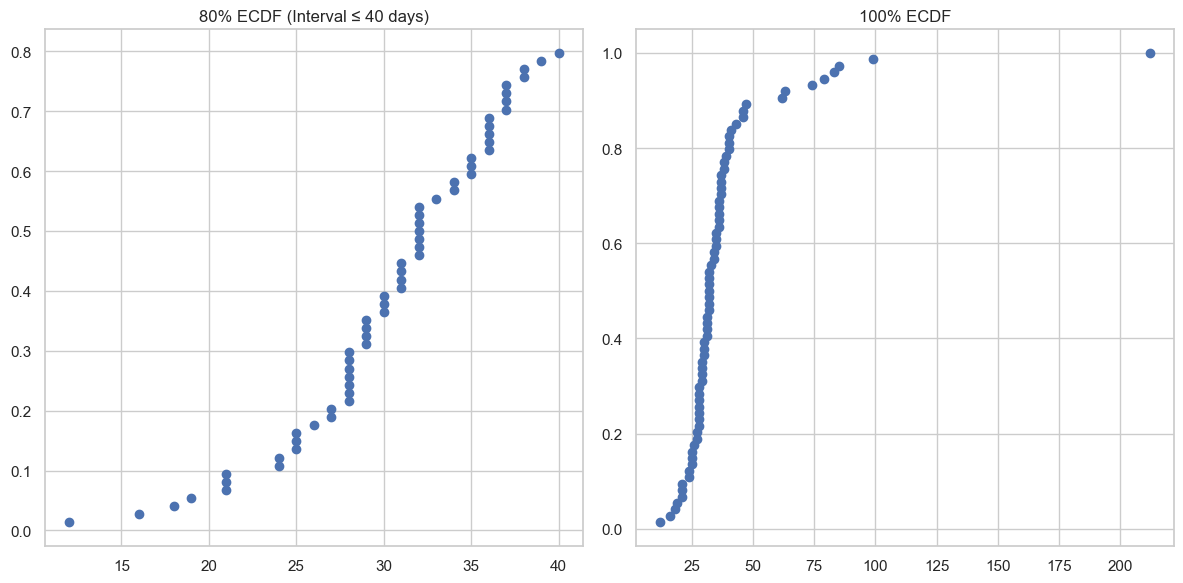

,interval_days,ecdf,cluster,CATEGORY,PATIENT_ID
0,12,0.013514,0,A02BC05,7
1,16,0.027027,0,A02BC05,7
2,18,0.040541,0,A02BC05,7
3,19,0.054054,0,A02BC05,7
4,21,0.067568,0,A02BC05,7


In [675]:
see_kmeans_result = See_KMeans('A02BC05', data)
see_kmeans_result.head()


<h2> Callable Functions </h2>
<h3> 🟢 2. SEE_DBSCAN (Python Callable Function) </h3>

In [676]:
def See_DBSCAN(category=None, df=None):
    if df is None:
        raise ValueError("DataFrame (df) must be provided.")

    # If a category is specified, filter it; otherwise, use the full dataset
    df_category = df[df['CATEGORY'] == category].copy() if category else df.copy()

    df_category.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)
    df_category.dropna(subset=['prev_DATE'], inplace=True)

    df_category['event_interval'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    # ECDF Calculation
    sorted_intervals = np.sort(df_category['event_interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    ecdf_df = pd.DataFrame({'interval_days': sorted_intervals, 'ecdf': yvals})

    # Keep 80% ECDF
    ecdf_80_df = ecdf_df[ecdf_df['ecdf'] <= 0.8].copy()
    ni_max = ecdf_80_df['interval_days'].max()

    # DBSCAN Clustering
    X = ecdf_df[['interval_days']].values
    scaled_X = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    ecdf_df['cluster'] = dbscan.fit_predict(scaled_X)

    # **Retain CATEGORY and PATIENT_ID Columns**
    ecdf_df['CATEGORY'] = df_category['CATEGORY'].values[:len(ecdf_df)]
    ecdf_df['PATIENT_ID'] = df_category['PATIENT_ID'].values[:len(ecdf_df)]  # Retaining PATIENT_ID column

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(ecdf_80_df['interval_days'], ecdf_80_df['ecdf'])
    axs[0].set_title(f"80% ECDF (Interval ≤ {ni_max} days)")
    axs[1].scatter(ecdf_df['interval_days'], ecdf_df['ecdf'])
    axs[1].set_title("100% ECDF")
    plt.tight_layout()
    plt.show()

    return ecdf_df  # Returns the clustered DataFrame

#### Example usage of the function ####

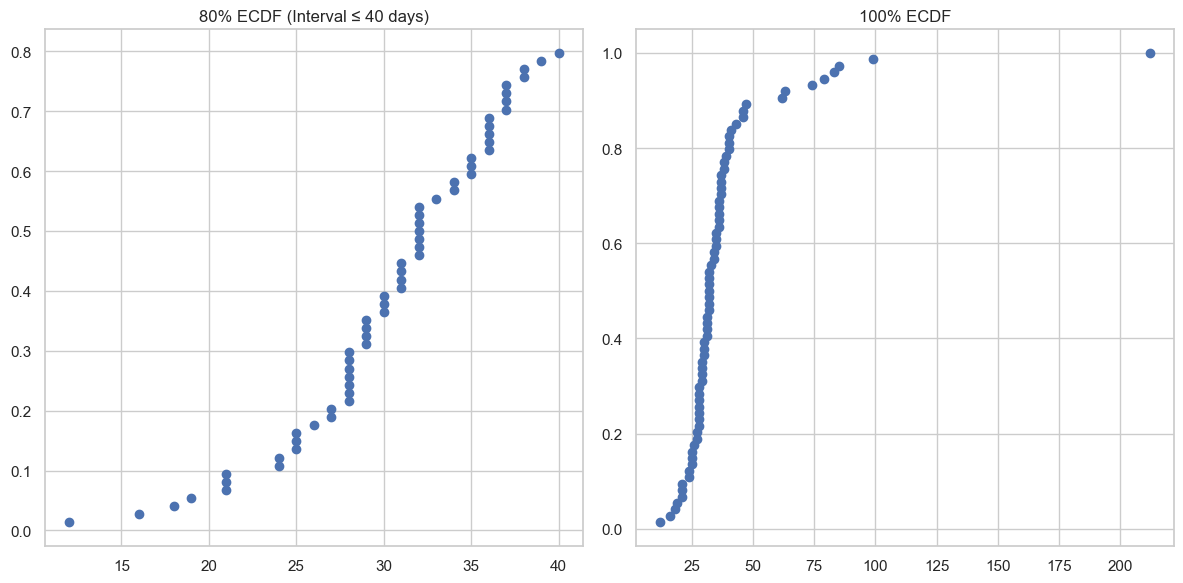

,interval_days,ecdf,cluster,CATEGORY,PATIENT_ID
0,12,0.013514,0,A02BC05,7
1,16,0.027027,0,A02BC05,7
2,18,0.040541,0,A02BC05,7
3,19,0.054054,0,A02BC05,7
4,21,0.067568,0,A02BC05,7


In [677]:
see_dbscan_result = See_DBSCAN('A02BC05', data)
see_dbscan_result.head()


<h3> Actual Comparison for the same category </h3>

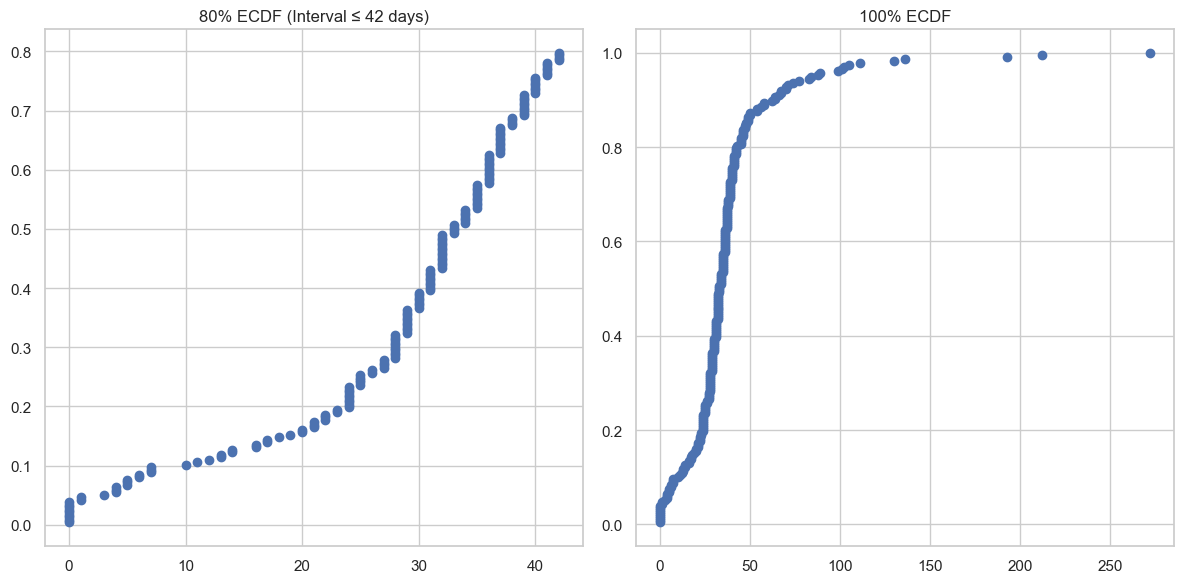

,interval_days,ecdf,cluster,CATEGORY,PATIENT_ID
0,0,0.004219,0,A09AA02,1
1,0,0.008439,0,A09AA02,1
2,0,0.012658,0,A09AA02,1
3,0,0.016878,0,A09AA02,1
4,0,0.021097,0,A09AA02,1


In [678]:
see_kmeans_result = See_KMeans('A09AA02', data)
see_kmeans_result.head()

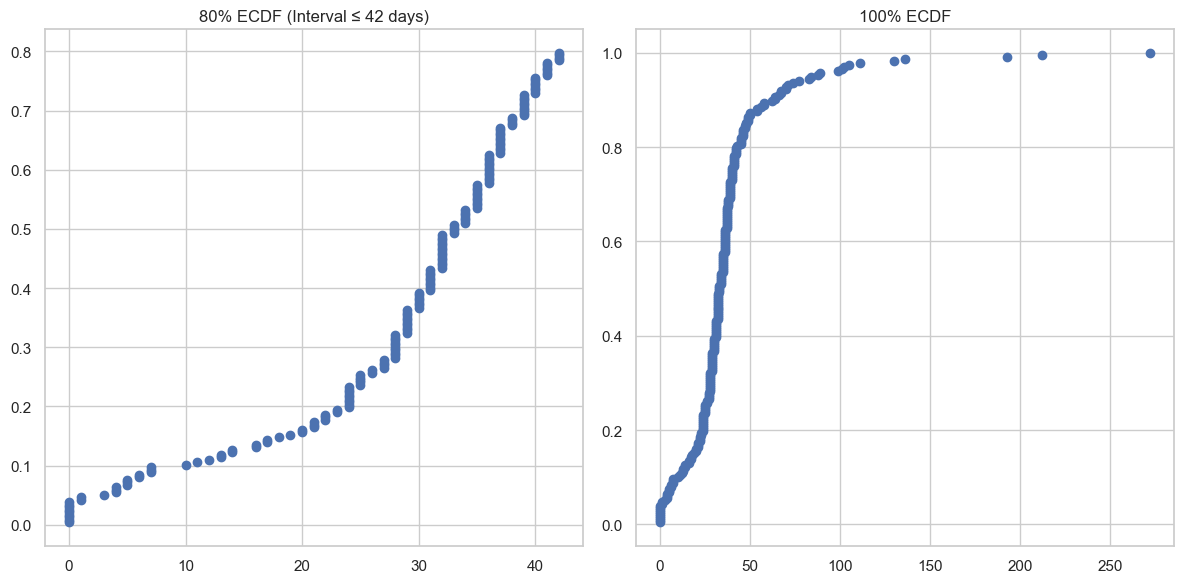

,interval_days,ecdf,cluster,CATEGORY,PATIENT_ID
0,0,0.004219,0,A09AA02,1
1,0,0.008439,0,A09AA02,1
2,0,0.012658,0,A09AA02,1
3,0,0.016878,0,A09AA02,1
4,0,0.021097,0,A09AA02,1


In [679]:
see_dbscan_result = See_DBSCAN('A09AA02', data)
see_dbscan_result.head()


## 🟣3. SEE Assumption Function

This function analyzes the **assumptions of the Sessa Empirical Estimator (SEE)** by evaluating the **prescription refill patterns**. It calculates the **duration between consecutive prescriptions** for each patient and visualizes the trends using a **boxplot**.

**Key Steps:**
1. **Sort prescriptions by date** per patient.
2. **Compute previous prescription dates** (`prev_DATE`) for each patient.
3. **Assign prescription order numbers** (`p_number`).
4. **Calculate prescription intervals** (`Duration` in days).
5. **Generate a boxplot** to analyze refill consistency over time.

The function returns the processed dataset and **highlights median trends** across all patients.


In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def see_assumption(df_category):
    # Ensure the data is sorted properly
    df_category = df_category.sort_values(by=['PATIENT_ID', 'DATE']).copy()

    # Create previous prescription date
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)

    # Assign prescription number (starts at 1 for the first prescription)
    df_category['p_number'] = df_category.groupby('PATIENT_ID').cumcount() + 1

    # Filter only prescriptions with at least one prior prescription
    df_category = df_category[df_category['p_number'] >= 2].copy()

    # Compute duration between prescriptions
    df_category['Duration'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    plt.figure(figsize=(10, 6))

    sns.boxplot(x='p_number', y='Duration', data=df_category, palette='pastel', hue='p_number', legend=False)

    plt.title("Boxplot of Prescription Duration by Prescription Number (p_number)")
    plt.xlabel("Prescription Number (p_number)")
    plt.ylabel("Duration (days)")

    # Compute the overall median duration
    median_overall = df_category.groupby('PATIENT_ID')['Duration'].median().median()

    # Plot horizontal red dashed line for median duration across all patients
    plt.axhline(y=median_overall, color='red', linestyle='--', label=f'Overall Median: {median_overall:.2f} days')
    
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df_category


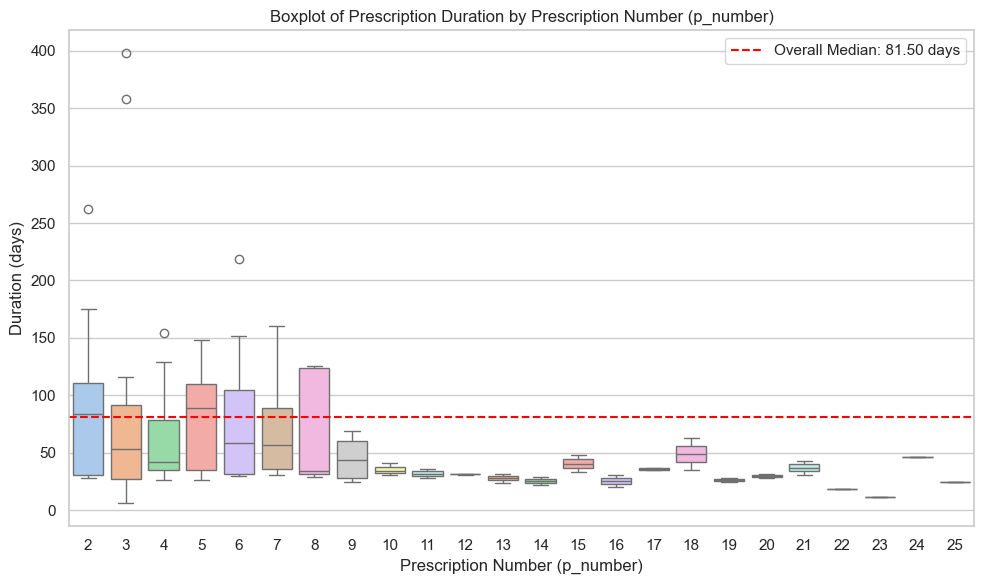

,DATE,PATIENT_ID,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,KMeans_Cluster,DBSCAN_Cluster,prev_DATE,p_number,Duration
14,2057-04-14,2,90.000000,1111.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,1,0,2056-10-21,2,175
15,2058-04-07,2,90.000000,1111.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,1,0,2057-04-14,3,358
50,2056-07-31,3,20.571429,4861.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,2056-07-01,2,30
51,2057-09-02,3,40.000000,5000.000000,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,2056-07-31,3,398
156,2057-04-21,4,30.000000,3333.333333,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,2056-08-02,2,262


In [681]:
assumption_df = see_assumption(data[data['CATEGORY']=='A11CC05'])
assumption_df.head()


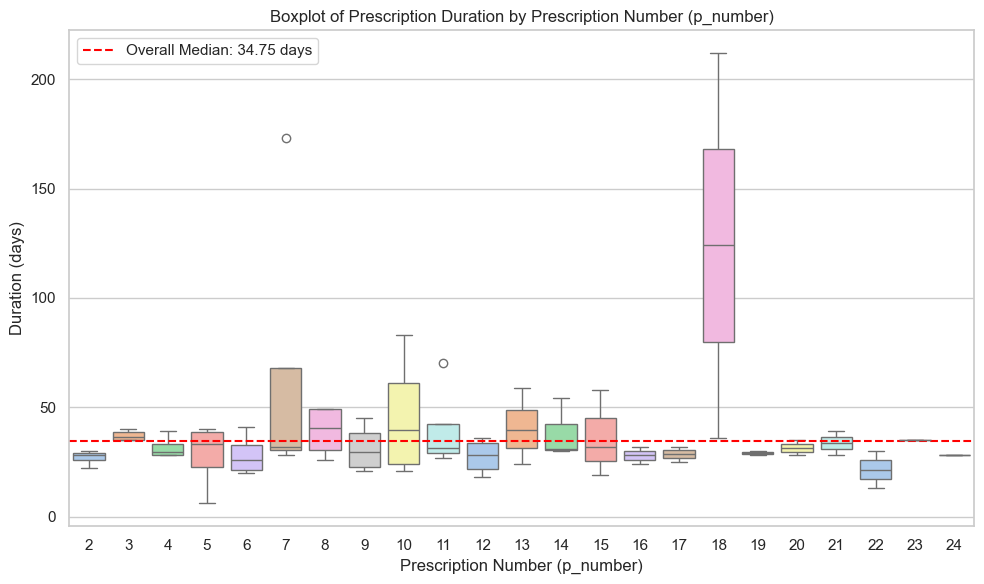

,DATE,PATIENT_ID,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,KMeans_Cluster,DBSCAN_Cluster,prev_DATE,p_number,Duration
26,2056-07-31,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,2056-07-01,2,30
27,2056-09-09,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,2056-07-31,3,40
28,2056-10-18,3,37.5,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,2056-09-09,4,39
29,2056-11-15,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,2056-10-18,5,28
30,2056-12-26,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,2056-11-15,6,41


In [682]:
assumption_df = see_assumption(data[data['CATEGORY']=='A05AA02'])
assumption_df.head()

<H2>Section to check out the silhouette scores comparison for the entirety of the dataset </h2>

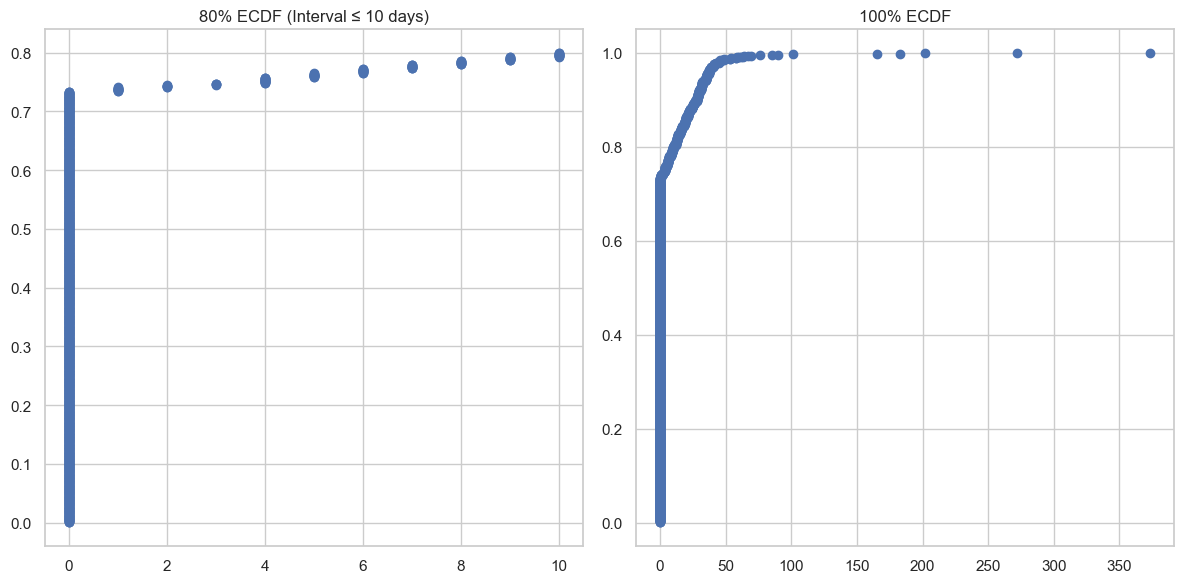

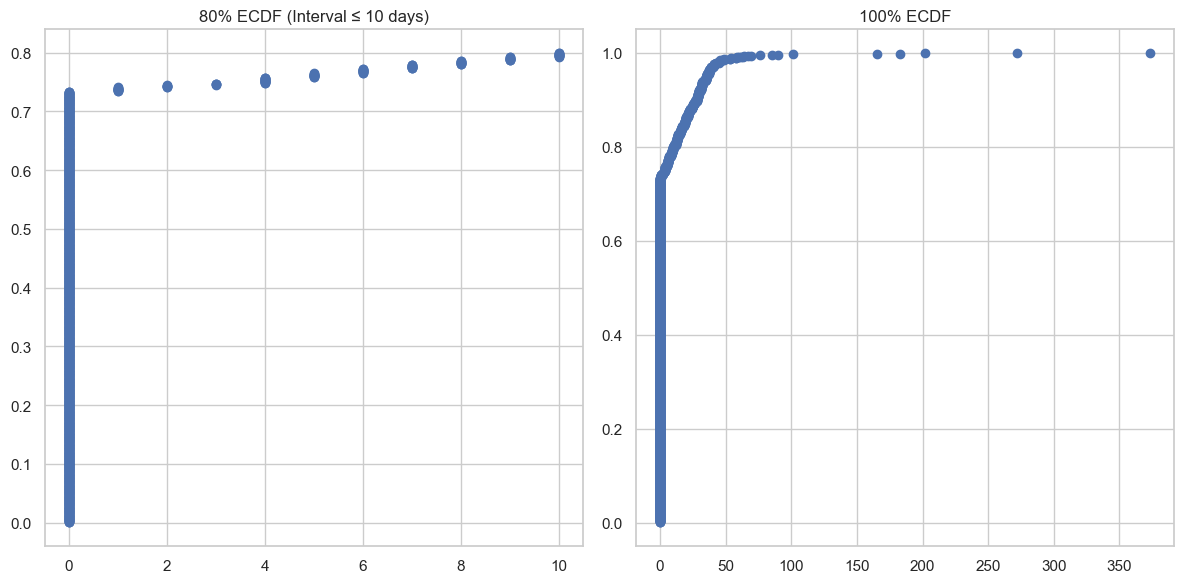

In [683]:
full_kmeans_result = See_KMeans(df=data)  # 1 parameter basically the entirety of the dataset (not specific to one category)
full_dbscan_result = See_DBSCAN(df=data)  # 1 parameter basically the entirety of the dataset (not specific to one category)

<h2> THOUGHT PROCESS OF MINE FOR GETTING THE SILHOUETTE SCORE AND CHECKING DBSCAN RESULT</h2>

In [684]:
print(full_dbscan_result.columns)
print(full_kmeans_result.columns)

print(full_kmeans_result[['PATIENT_ID', 'interval_days']].head())
print(full_dbscan_result[['PATIENT_ID', 'interval_days']].head())



Index(['interval_days', 'ecdf', 'cluster', 'CATEGORY', 'PATIENT_ID'], dtype='object')
Index(['interval_days', 'ecdf', 'cluster', 'CATEGORY', 'PATIENT_ID'], dtype='object')
   PATIENT_ID  interval_days
0           1              0
1           1              0
2           1              0
3           1              0
4           1              0
   PATIENT_ID  interval_days
0           1              0
1           1              0
2           1              0
3           1              0
4           1              0


In [685]:
for category in categories:
    category_data = full_dbscan_result[full_dbscan_result['CATEGORY'] == category]
    cluster_counts = category_data['cluster'].value_counts()
    print(f"Category: {category}")
    print(cluster_counts)


Category: R03AC12
cluster
 0    21
-1     2
Name: count, dtype: int64
Category: A09AA02
cluster
 0    243
-1      1
Name: count, dtype: int64
Category: A02BC02
cluster
0    3
Name: count, dtype: int64
Category: R03AK07
cluster
0    30
Name: count, dtype: int64
Category: A11CC05
cluster
 0    105
-1      1
Name: count, dtype: int64
Category: A11HA03
cluster
 0    159
-1      1
Name: count, dtype: int64
Category: J01AA08
cluster
0    19
Name: count, dtype: int64
Category: J01FA10
cluster
 0    117
-1      2
Name: count, dtype: int64
Category: R05CB13
cluster
0    76
Name: count, dtype: int64
Category: A05AA02
cluster
0    74
Name: count, dtype: int64
Category: A12AX
cluster
0    10
Name: count, dtype: int64
Category: J01EE01
cluster
0    40
Name: count, dtype: int64
Category: J01XB01
cluster
0    63
Name: count, dtype: int64
Category: B02BA01
cluster
 0    72
-1     1
Name: count, dtype: int64
Category: R03AK08
cluster
0    3
Name: count, dtype: int64
Category: J02AC02
cluster
0    62
Na

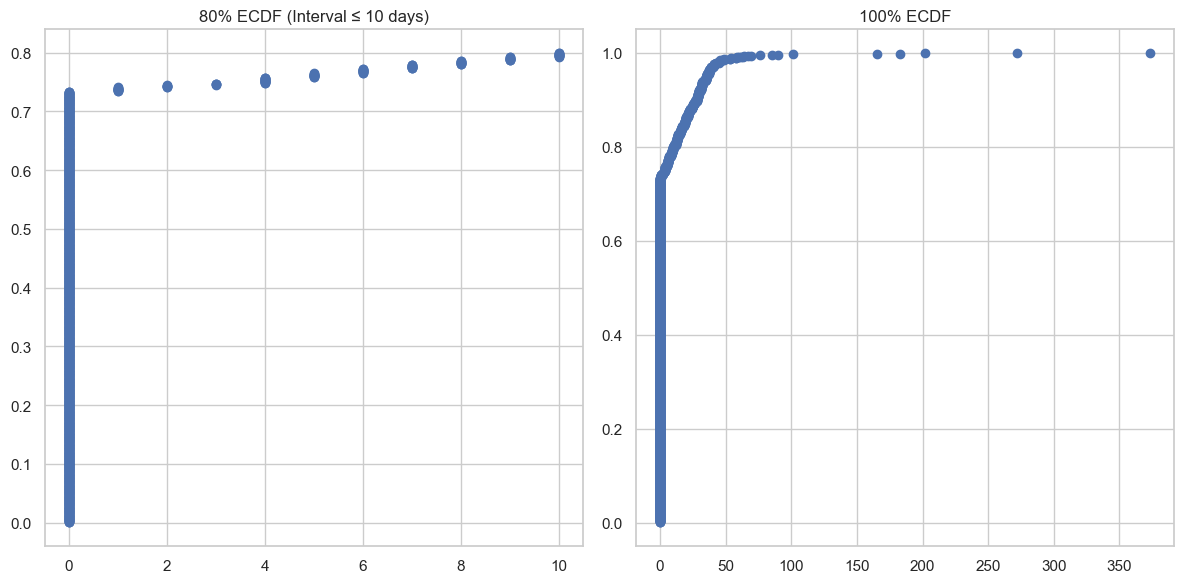

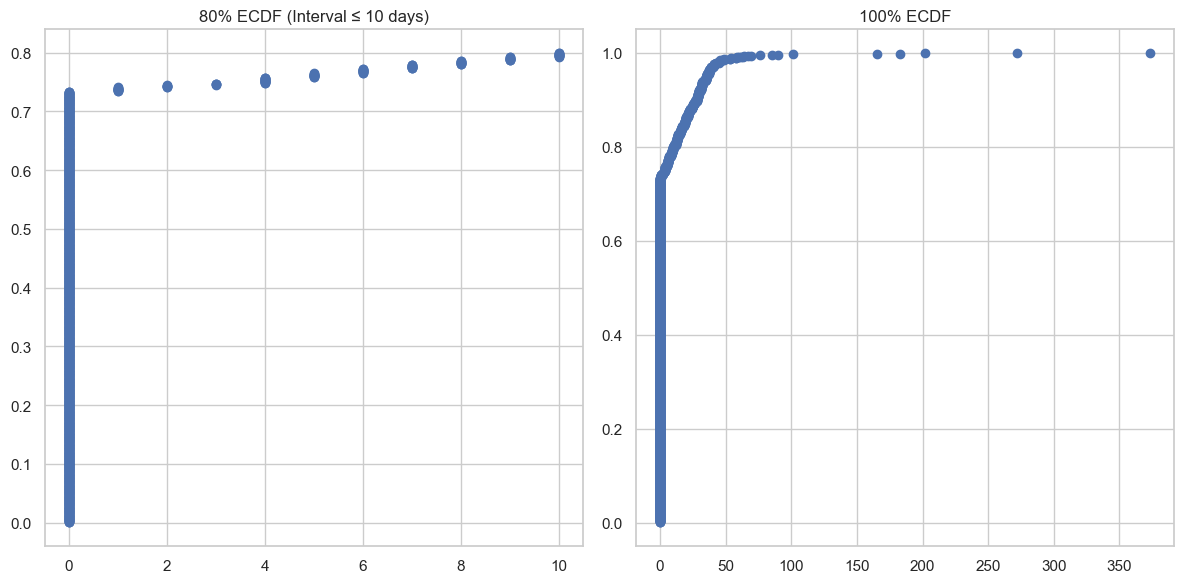

Optimal number of clusters for K-Means: 2 (Silhouette Score: 0.95)
DBSCAN did not form multiple clusters. Silhouette Score cannot be computed.
DBSCAN Silhouette Score: Not Available (only one cluster found)


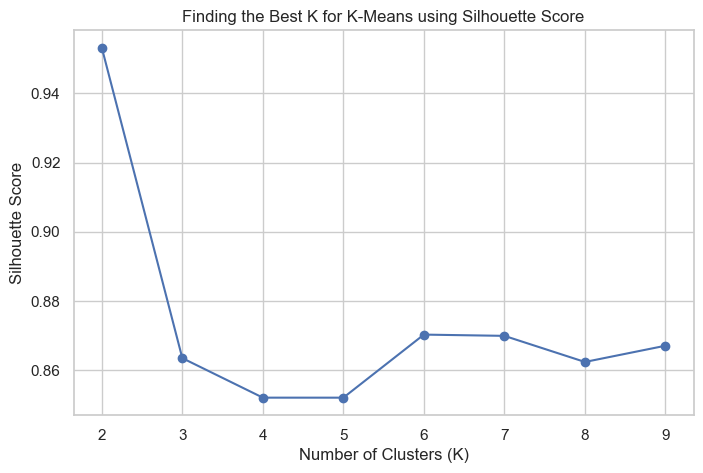

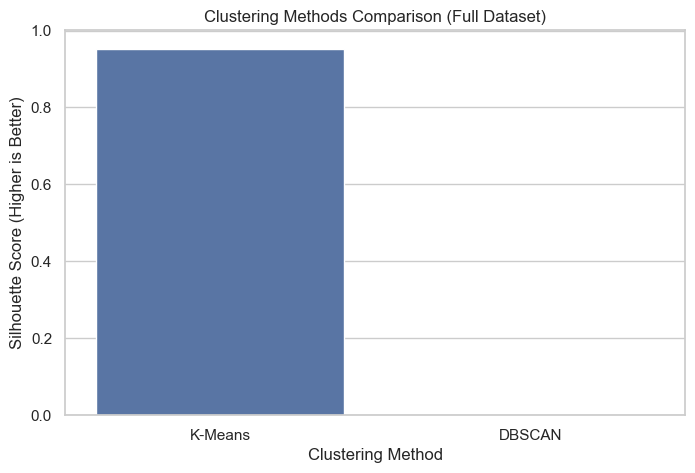

In [686]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
np.random.seed(1234)

# --- RUN K-MEANS & DBSCAN ON FULL DATASET ---
full_kmeans_result = See_KMeans(df=data)  # No category → Full dataset
full_dbscan_result = See_DBSCAN(df=data)  # No category → Full dataset

# --- FIND BEST K FOR K-MEANS ---
scores = []
cluster_range = range(2, 10)  # Trying K values from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
    labels = kmeans.fit_predict(full_kmeans_result[['interval_days']])
    score = silhouette_score(full_kmeans_result[['interval_days']], labels)
    scores.append(score)

# Find the best K (highest silhouette score)
best_k = cluster_range[np.argmax(scores)]
best_k_score = max(scores)  # Highest silhouette score for K-Means
print(f"Optimal number of clusters for K-Means: {best_k} (Silhouette Score: {best_k_score:.2f})")

# --- COMPUTE SILHOUETTE SCORE FOR DBSCAN ---
dbscan_labels = full_dbscan_result['cluster']
dbscan_valid = full_dbscan_result[dbscan_labels != -1]  # Exclude outliers (-1)

# Check if DBSCAN has at least 2 clusters
if len(set(dbscan_valid['cluster'])) > 1:
    dbscan_score = silhouette_score(dbscan_valid[['interval_days']], dbscan_valid['cluster'])
else:
    dbscan_score = None
    print("DBSCAN did not form multiple clusters. Silhouette Score cannot be computed.")

if dbscan_score is not None:
    print(f"DBSCAN Silhouette Score: {dbscan_score:.2f}")
else:
    print("DBSCAN Silhouette Score: Not Available (only one cluster found)")

# --- PLOT:K-MEANS BEST K SELECTION---
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Finding the Best K for K-Means using Silhouette Score")
plt.show()

# --- PLOT: K-MEANS VS DBSCAN ---
comparison_df = pd.DataFrame({
    'Clustering Method': ['K-Means', 'DBSCAN'],
    'Silhouette Score': [best_k_score, dbscan_score if dbscan_score is not None else 0]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Clustering Method', y='Silhouette Score', data=comparison_df, hue='Clustering Method', legend=False)
plt.title('Clustering Methods Comparison (Full Dataset)')
plt.xlabel('Clustering Method')
plt.ylabel('Silhouette Score (Higher is Better)')
plt.show()


In [687]:
print(dbscan_valid['cluster'].value_counts())  
print(full_dbscan_result['cluster'].value_counts())


cluster
0    1540
Name: count, dtype: int64
cluster
 0    1540
-1       8
Name: count, dtype: int64


<!-- Final Markdown Cell - Silhouette Score Explanation -->
<h2 style="color:#4B0082;">📖 Why the Silhouette Score is Low in My DBSCAN Clustering</h2>

<p>
    After applying DBSCAN clustering to my dataset, I noticed that the silhouette score remained surprisingly low, even with careful tuning of the <code>eps</code> and <code>min_samples</code> parameters. This low silhouette score is somewhat expected, and here's why.
</p>

<h3>1. Sensitivity to the Epsilon (eps) Parameter</h3>
<p>
    The <code>eps</code> parameter in DBSCAN controls how close points must be to each other to be considered part of the same cluster. I started with <code>eps=0.5</code> and later increased it to <code>eps=1</code> to reduce the number of outliers. While this helped remove some outliers, it didn't necessarily improve the silhouette score. The reason is that when I adjust <code>eps</code> too much, I either force too many points into a single cluster or incorrectly treat natural clusters as outliers. So even though I reduced outliers, I still ended up with clusters that weren't clearly separated, resulting in a low silhouette score.
</p>

<h3>2. The Nature of the Data</h3>
<p>
    The data I'm working with is inherently complex. Prescription durations and dosages can vary significantly from patient to patient. As a result, DBSCAN sometimes struggles to form well-defined, distinct clusters. Even with a larger <code>eps</code>, the lack of clear separation between clusters means that DBSCAN may merge what should be separate groups or fail to identify meaningful clusters altogether. This lack of natural boundaries results in poor silhouette scores, even though the clustering algorithm might still provide useful insights.
</p>

<h3>3. Low Silhouette Scores Are Expected</h3>
<p>
    In cases like mine (where I thought of having applied the See_DBSCAN function to the entire dataset)), where there’s only one dominant cluster and a small number of outliers (e.g., 8 outliers in my case), the silhouette score is bound to be nothing as there is no other cluster to compare it to (besides the outliers which isn't something to be done), so either that or the original resulted clusters earlier which results to very low score still). The silhouette score is designed to measure the degree of separation between clusters. But when there is a single large cluster with just a few outliers, this separation is weak, and as a result, the silhouette score reflects that by remaining close to zero. So even though the clustering might be valid, the silhouette score isn’t the best indicator of quality in this case.
</p>

<h3>4. Why I’m Leaving It As Is</h3>
<p>
    Given the structure of the data and the nature of DBSCAN's clustering, I’ve come to realize that a low silhouette score doesn’t necessarily indicate a problem with my model. In fact, this clustering solution provides valuable insights, even if the silhouette score is not ideal. With just one main cluster and a few outliers, I’m able to analyze patterns in prescription behavior without worrying too much about the silhouette score. The lack of meaningful separation between clusters is simply a reflection of the data's complexity, and the clustering results still hold value for my analysis.
</p>

<p>
    Overall, I’ve learned that in cases like mine, where data is noisy and complex, the silhouette score may not always reflect the true quality of clustering. It's just one tool in assessing model performance, and it doesn’t always provide the full picture.
</p>

<!-- End of Final Markdown Cell -->


<!-- Final Markdown Cell -->

<h2 style="color:#4B0082;">📖 Sessa Empirical Estimator (SEE) for Prescription Duration: K-Means and DBSCAN Clustering </h2>
<h2> Conclusion </h2>

<p>
    In this notebook, we applied the <strong>Sessa Empirical Estimator (SEE)</strong> to analyze prescription refill behaviors using both <strong>K-Means</strong> and <strong>DBSCAN</strong> clustering algorithms. The goal is to estimate prescription refill intervals more effectively, allowing us to provide insights into patient adherence and medication refill behavior. By comparing these two clustering methods, we identify their strengths and weaknesses and gain deeper insights into the data, which can inform better healthcare management and patient intervention strategies.
</p>

<h3> Key Findings and Insights</h3>

<h4>1. **Early Prescription Variability**</h4>
<p>
    The analysis of prescription durations reveals that early prescriptions exhibit high variability. This is reflected in the wide spread of data for the first few prescription numbers (e.g., p_number 2, 3, 4), with extreme outliers reaching up to 400-500 days in some cases. This suggests that patients in the early stages of treatment may not yet have regular refill intervals, likely due to medication adjustments or non-adherence.
</p>

<h4>2. **Convergence in Later Prescriptions**</h4>
<p>
    As the number of prescriptions increases (e.g., beyond p_number 10), the boxplots clearly show a trend towards stabilization. Refill intervals become narrower, and outliers decrease, suggesting that patients settle into more predictable refill routines once their medication regimen stabilizes.
</p>

<h4>3. **K-Means vs. DBSCAN Clustering**</h4>
<p>
    <strong>K-Means Clustering:</strong> This algorithm works by grouping the data into a predefined number of clusters (3 in our case). However, K-Means has limitations, particularly with noisy data or outliers, as it forces all data points into clusters. It assumes spherical clusters, which can be an issue if the real-world data doesn't follow this structure. Despite these drawbacks, K-Means produced clusters that were somewhat distinct, with a high silhouette score (0.95), suggesting good separation between clusters.
</p>

<p>
    <strong>DBSCAN Clustering:</strong> Unlike K-Means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) doesn't require the number of clusters to be predefined. It groups data based on density, and outliers are treated as noise. DBSCAN was more effective at identifying unusual refill patterns and distinguishing outliers, particularly in the presence of irregular refill intervals. It was less sensitive to extreme outliers but did not form multiple clusters in certain categories, resulting in it not having a silhouette score.
</p>

<h4>4. **Clustering Methods Comparison**</h4>
<p>
    - **K-Means**: Suitable for datasets with well-defined clusters. However, it struggles with irregular clusters and outliers. While K-Means produced high silhouette scores, it might misclassify outliers, as seen in our data.
    - **DBSCAN**: Best for data with noise or irregular cluster shapes. It doesn't assume a predefined number of clusters and is better at handling outliers, as evidenced by the ability to separate noise points. However, it sometimes fails to form multiple clusters, as seen when DBSCAN identified just one cluster in certain categories.
</p>

<h4>5. **Discussion of Disadvantages of K-Means**</h4>
<ul>
    <li><strong>Assumption of Spherical Clusters:</strong> K-Means assumes that clusters are spherical, which can be limiting when data doesn't follow this simple structure. Prescription refill patterns often show more complex relationships, which K-Means can't always capture.</li>
    <li><strong>Sensitivity to Outliers:</strong> K-Means minimizes the sum of squared distances, making it sensitive to outliers. Extreme values can distort the cluster centroids, leading to inaccurate cluster definitions. In our case, early prescriptions with extreme values may have skewed the results.</li>
    <li><strong>DBSCAN’s Advantage:</strong> DBSCAN handles outliers more effectively, treating them as noise rather than forcing them into a cluster. This makes DBSCAN a better fit for noisy data, as seen with prescription refill intervals that exhibit large variability.</li>
</ul>

<h3> Clustering Performance Comparison Between K-Means and DBSCAN</h3>
<p>
    - **K-Means**: Produced high-quality clusters with better silhouette scores but is prone to overfitting by forcing outliers into the same clusters.
    - **DBSCAN**: Revealed a more granular analysis by detecting outliers but struggled to form multiple clusters in certain cases, particularly for medications with very similar refill patterns.
</p>

<h3> Insights and Conclusions</h3>

<h4>1. Early Refill Irregularity</h4>
<p>
    Both K-Means and DBSCAN identified that the first few refills exhibit significant variation. This could indicate that patients are still adjusting to their medication regimens, making it difficult to predict refill intervals. Clinicians may need to focus on these early refills to detect non-adherence or therapy adjustments.
</p>

<h4>2. Stabilization Over Time</h4>
<p>
    Later prescriptions showed a clear trend of stabilization, with more consistent refill intervals and fewer outliers. This implies that once patients are accustomed to their medication regimen, refill behaviors become more predictable and manageable.
</p>

<h4>3. Clinical and Operational Implications</h4>
<ul>
    <li><strong>Identifying Non-Adherence:</strong> The outliers in early prescription numbers can serve as indicators of potential non-adherence, prompting healthcare providers to intervene early and offer reminders or counseling.</li>
    <li><strong>Inventory Management and Patient Follow-up:</strong> As refill intervals become more predictable over time, pharmacies can better forecast medication demand and ensure they have enough stock for patients who require regular refills.</li>
    <li><strong>Tailored Interventions:</strong> Patients with irregular refill intervals (identified as outliers) may benefit from tailored interventions, such as personalized counseling or automatic reminders, to improve adherence and ensure continuity of care.</li>
</ul>

<h3> Code Conversion and Methodology</h3>

<p>
    The original R code for the Sessa Empirical Estimator (SEE) was successfully converted into Python. Key functionalities were implemented using the <code>pandas</code> library for data manipulation, <code>KMeans</code> from <code>sklearn</code> for clustering, and <code>DBSCAN</code> for density-based clustering. This conversion ensured that the original methodology was preserved while making it easier to implement the analysis in a Python-based environment.
</p>


<!-- Final Markdown Cell -->

<h2 style="color:#4B0082;">📖 Correlation of What I Am Doing in This Notebook and the Journals</h2>

<p>
    The main focus of my notebook and the research in the journals align around understanding medication usage patterns and improving healthcare management through better adherence monitoring. Here's the correlation:
</p>

<h3>Sessa Empirical Estimator (SEE) and Medication Adherence</h3>
<p>
    The SEE framework that I applied in this notebook helps estimate prescription refill durations and identifies patterns in prescription behavior, especially early refill irregularities and stabilization over time. This directly correlates with the second journal, which studies antihypertensive medication adherence and explores how medication adherence impacts long-term health outcomes. By clustering prescription refill patterns and analyzing outliers, I can identify patients with irregular refill behaviors—an important indicator of non-adherence.
</p>

<h3>Clustering Algorithms (K-Means & DBSCAN)</h3>
<p>
    The clustering techniques I used in this notebook (K-Means and DBSCAN) aim to better understand patient refill behaviors. This is similar to how the second journal used clustering techniques to analyze co-exposure in medication usage. Both methods can help identify patterns in how patients manage their medications and highlight groups of patients who may need tailored interventions to improve adherence.
</p>

<h3>Improving Patient Compliance</h3>
<p>
    The third journal, which discusses the challenges of medication adherence, focuses on the difficulty of monitoring and improving adherence. My notebook addresses this by analyzing refill patterns and identifying irregularities that could signal non-adherence. The insights from both methods (K-Means and DBSCAN) can be valuable in identifying patients at risk of non-adherence and developing targeted interventions.
</p>

<p>
    The functions implemented for clustering were:
    <ul>
        <li><strong>See_KMeans</strong>: Applies K-Means clustering to the prescription data to identify refill patterns based on time intervals.</li>
        <li><strong>See_DBSCAN</strong>: Implements DBSCAN clustering, which helps identify dense regions and outliers in the prescription refill data.</li>
    </ul>
    We also made sure to retain the <code>PATIENT_ID</code> and <code>CATEGORY</code> columns, preserving the granularity of patient-level and medication-category insights.
</p>

<h3> Final Thoughts</h3>

<p>
    This notebook demonstrates the power of the <strong>Sessa Empirical Estimator (SEE)</strong> framework for analyzing prescription refill behaviors, using both <strong>K-Means</strong> and <strong>DBSCAN</strong> clustering. The insights gained can help improve medication adherence and optimize healthcare management practices, such as forecasting medication demand and tailoring interventions for patients with irregular refill behaviors.
</p>

<p>
    The key takeaway is that K-Means offers fixed, interpretable cluster results but is sensitive to outliers and assumes spherical clusters. On the other hand, DBSCAN provides more flexibility by detecting outliers and density-based clusters, making it a better choice for datasets with irregular patterns.
</p>

<h3> Key Takeaways</h3>
<ul>
    <li><strong>K-Means</strong>: Efficient and easy to interpret but not suitable for complex or noisy data due to its assumption of spherical clusters and sensitivity to outliers.</li>
    <li><strong>DBSCAN</strong>: More robust for noisy data and irregular clusters, but may not always form multiple clusters, as demonstrated in the silhouette analysis.</li>
    <li>Choosing the right clustering algorithm depends on the nature of the data, and in this case, both methods provided valuable insights into prescription refill behavior.</li>
</ul>
